# ActBlue basic details

In [2]:
import json
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import os
import requests

In [3]:
%matplotlib inline

plt.style.use('ggplot')

pd.options.display.float_format = '{:,.2f}'.format

In [4]:
def read_or_save(name, func):
    path = 'pickles/' + name + '.pickle.gz'
    if (os.path.isfile(path)):
        return pd.read_pickle(path)
    else:
        result = func()
        os.makedirs('pickles', exist_ok=True)
        result.to_pickle(path)
        return result

In [5]:
committee_id = "C00401224"
year_since = 2012

### Connect to the PostgreSQL database

In [6]:
with open("config.json") as f:
    conf = json.load(f)
conn = psycopg2.connect(
    dbname=conf['dbname'],
    user=conf['user'],
    host=conf['host'],
    password=conf['password']
)

### How many reports are in the database?

In [7]:
read_or_save(
    'filings_count',
    lambda: pd.read_sql("""
    SELECT count(*)
    FROM fec_filings;
    """, con=conn)
)

,count
0,360497


### Which ActBlue reports do we have?

In [8]:
actblue_summaries = read_or_save(
    'actblue_summaries',
    lambda: pd.read_sql("""
    SELECT *
    FROM fec_pac_summaries
    JOIN fec_amended_filings USING (filing_id)
    WHERE filer_committee_id_number = '""" + committee_id + """'
    AND extract(year from coverage_through_date) > """ + str(year_since) + """
    ORDER BY coverage_through_date DESC;
    """, con=conn, parse_dates={
        'coverage_from_date': '%Y-%m-%d',
        'coverage_through_date': '%Y-%m-%d'
    })
)

actblue_summaries[[
    'filing_id',
    'form_type',
    'committee_name',
    'coverage_from_date',
    'coverage_through_date',
    'report_code',
    'col_a_total_contributions'
]]

,filing_id,form_type,committee_name,coverage_from_date,coverage_through_date,report_code,col_a_total_contributions
0,1258193,F3XN,ActBlue,2018-07-01,2018-07-31,M8,"60,945,546.97"
1,1251343,F3XN,ActBlue,2018-06-01,2018-06-30,M7,"63,088,119.19"
2,1240253,F3XN,ActBlue,2018-05-01,2018-05-31,M6,"43,130,233.11"
3,1233520,F3XN,ActBlue,2018-04-01,2018-04-30,M5,"38,328,646.45"
4,1225971,F3XN,ActBlue,2018-03-01,2018-03-31,M4,"57,825,086.02"
5,1215697,F3XN,ActBlue,2018-02-01,2018-02-28,M3,"41,932,847.30"
6,1224404,F3XA,ActBlue,2018-01-01,2018-01-31,M2,"32,937,704.67"
7,1224416,F3XA,ActBlue,2017-12-01,2017-12-31,YE,"51,181,861.72"
8,1219434,F3XA,ActBlue,2017-11-01,2017-11-30,M12,"36,180,318.82"
9,1219420,F3XA,ActBlue,2017-10-01,2017-10-31,M11,"29,341,844.16"


### Are there any reports that FEC.gov has that we don't or vice versa?

In [9]:
def get_reports(committee_id):
    base = "https://api.open.fec.gov/v1/"
    url = base + "committee/" + committee_id + "/reports/?api_key=" + conf['fec_key'] + "&is_amended=False&per_page=100"

    return pd.DataFrame(requests.get(url).json()['results'])

actblue_api_summaries = read_or_save('actblue_api_summaries', lambda: get_reports(committee_id))
pd.to_numeric(actblue_api_summaries['calendar_ytd'])
actblue_api_summaries = actblue_api_summaries[actblue_api_summaries['calendar_ytd'] > year_since]
actblue_api_summaries[['file_number','calendar_ytd']]

pd.DataFrame(pd.concat([actblue_api_summaries['file_number'],
                        actblue_summaries['filing_id']]).drop_duplicates(keep=False))

,0
0,1258193


### How have contributions changed over time?

Text(0.5,1,'Total contributions by reporting period')

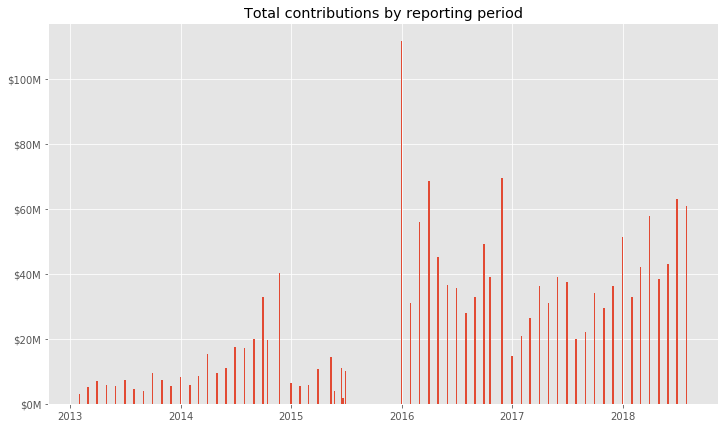

In [10]:
contribs_over_time = actblue_summaries[['coverage_through_date','col_a_total_contributions']]

# https://scentellegher.github.io/programming/2017/05/24/pandas-bar-plot-with-formatted-dates.html
contribs_over_time.set_index('coverage_through_date',inplace=True)

fig, ax = plt.subplots(figsize=(12,7))

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# https://matplotlib.org/examples/pylab_examples/custom_ticker1.html
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '$%1.fM' % (x*1e-6)))

ax.bar(contribs_over_time.index, contribs_over_time['col_a_total_contributions'], width=5)

ax.set_title('Total contributions by reporting period')

In [11]:
contribs_by_year = pd.DataFrame(
    actblue_summaries.groupby(actblue_summaries.coverage_through_date.dt.year)['col_a_total_contributions'].sum()
)
contribs_by_year

,col_a_total_contributions
coverage_through_date,
2013,"72,982,794.21"
2014,"203,718,311.99"
2015,"174,548,526.96"
2016,"505,359,517.22"
2017,"383,829,198.73"
2018,"338,188,183.71"


Text(0.5,1,'Total contributions by year')

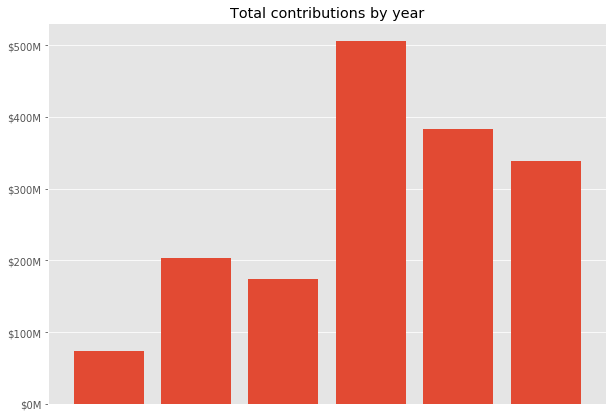

In [12]:
# https://scentellegher.github.io/programming/2017/05/24/pandas-bar-plot-with-formatted-dates.html
# contribs_by_year.set_index('coverage_through_date',inplace=True)

fig, ax = plt.subplots(figsize=(10,7))

ax.xaxis.set_major_locator(mdates.YearLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# https://matplotlib.org/examples/pylab_examples/custom_ticker1.html
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '$%1.fM' % (x*1e-6)))

ax.bar(contribs_by_year.index, contribs_by_year['col_a_total_contributions'], width=0.8)

ax.set_title('Total contributions by year')

### How many Democratic campaigns use ActBlue?

In [13]:
actblue_transfers = read_or_save(
    'actblue_transfers',
    lambda: pd.read_sql("""
    SELECT fec_committees.name,
           totals.*
    FROM
      (SELECT beneficiary_committee_fec_id,
              count(*),
              sum(expenditure_amount)
       FROM fec_expenditures
       WHERE filing_id IN
           (SELECT filing_id
            FROM fec_pac_summaries
            JOIN fec_amended_filings USING (filing_id)
            WHERE filer_committee_id_number = '""" + committee_id + """'
              AND extract(YEAR
                          FROM coverage_through_date) > """ + str(year_since) + """
            ORDER BY coverage_through_date DESC)
         AND form_type = 'SB23'
       GROUP BY beneficiary_committee_fec_id) AS totals
    LEFT JOIN fec_committees ON beneficiary_committee_fec_id = fec_committees.id
    """, con=conn)
)
actblue_transfers.sort_values(by=['sum'], ascending=False)

,name,beneficiary_committee_fec_id,count,sum
1594,DCCC,C00000935,10806481,"223,020,844.39"
3239,BERNIE 2016,C00577130,6955993,"180,898,812.29"
2468,DSCC,C00042366,3241260,"90,677,471.91"
610,END CITIZENS UNITED,C00573261,3318345,"44,599,395.83"
2262,JON OSSOFF FOR CONGRESS,C00630426,1430332,"27,468,759.69"
2089,DOUG JONES FOR SENATE COMMITTEE,C00640623,756705,"21,896,543.77"
806,PROGRESSIVE TURNOUT PROJECT,C00580068,1319286,"17,920,662.91"
107,BETO FOR TEXAS,C00501197,520462,"17,471,507.07"
2948,DNC SERVICES CORP./DEM. NAT'L COMMITTEE,C00010603,650085,"14,314,268.47"
172,GILLIBRAND FOR SENATE,C00413914,384731,"14,125,472.02"


In [14]:
actblue_proportion = read_or_save(
    'actblue_proportion',
    lambda: pd.read_sql("""
    SELECT actblue,
           count(*)
    FROM
      (SELECT cand_id,
              cand_pcc,
              CASE
                  WHEN COUNT IS NOT NULL THEN TRUE
                  ELSE FALSE
              END AS actblue
       FROM (SELECT DISTINCT ON (cand_id,
                               cand_pcc) *
           FROM fec_candidates
           WHERE cand_election_yr = '2018'
             AND cand_pcc IS NOT NULL
             AND cand_pty_affiliation IN ('DFL',
                                      'DEM')
           ORDER BY cand_id,
                    cand_pcc) AS cands
       LEFT JOIN
         (SELECT fec_committees.name,
                 totals.*
          FROM
            (SELECT beneficiary_committee_fec_id,
                    count(*) AS COUNT,
                    sum(expenditure_amount)
             FROM fec_expenditures
             WHERE filing_id IN
                 (SELECT filing_id
                  FROM fec_pac_summaries
                  JOIN fec_amended_filings USING (filing_id)
                  WHERE filer_committee_id_number = '""" + committee_id + """'
                    AND extract(YEAR
                                FROM coverage_through_date) >= 2017
                  ORDER BY coverage_through_date DESC)
               AND form_type = 'SB23'
             GROUP BY beneficiary_committee_fec_id) AS totals
          JOIN fec_committees ON beneficiary_committee_fec_id = fec_committees.id) AS actblue_committees ON cand_pcc = beneficiary_committee_fec_id) AS actblue_candidates
    GROUP BY actblue
    """, con=conn)
)

actblue_proportion

,actblue,count
0,False,233
1,True,1297


In [15]:
actblue_proportion_amount = read_or_save(
    'actblue_proportion_amount',
    lambda: pd.read_sql("""
    SELECT cand_pcc,
           array_agg(coverage_from_date) AS from_dates,
           array_agg(coverage_through_date) AS through_dates,
           sum(col_a_total_individual_contributions) AS committee_total,
           sum(actblue_total) AS actblue_total
    FROM
      (SELECT cand_pcc,
              coverage_from_date,
              coverage_through_date,
              col_a_total_individual_contributions,
              sum(expenditure_amount) AS actblue_total
       FROM
         (SELECT cand_id,
                 cand_pcc,
                 coverage_from_date,
                 coverage_through_date,
                 col_a_total_individual_contributions
          FROM
            (SELECT DISTINCT ON (cand_id,
                                 cand_pcc) *
             FROM fec_candidates
             WHERE cand_election_yr = '2018'
               AND cand_pty_affiliation IN ('DFL',
                                            'DEM')
               AND cand_pcc IS NOT NULL
             ORDER BY cand_id,
                      cand_pcc) AS cands
          JOIN fec_campaign_summaries ON cand_pcc = filer_committee_id_number
          JOIN fec_amended_filings USING (filing_id)
          WHERE extract(YEAR
                        FROM coverage_through_date) >= 2017
            AND coverage_through_date <= '2018-06-30'::date
          UNION SELECT cand_id,
                       cand_pcc,
                       coverage_from_date,
                       coverage_through_date,
                       col_a_total_individual_contributions
          FROM
            (SELECT DISTINCT ON (cand_id,
                                 cand_pcc) *
             FROM fec_candidates
             WHERE cand_election_yr = '2018'
               AND cand_pty_affiliation IN ('DFL',
                                            'DEM')
               AND cand_pcc IS NOT NULL
             ORDER BY cand_id,
                      cand_pcc) AS cands
          JOIN
            ( SELECT DISTINCT ON (filer_committee_id_number,
                                  coverage_from_date,
                                  coverage_through_date) filing_id,
                                 filer_committee_id_number,
                                 col_a_total_individual_contributions,
                                 coverage_from_date,
                                 coverage_through_date
             FROM fec_paper_campaign_summaries
             WHERE col_a_total_individual_contributions IS NOT NULL
             ORDER BY filer_committee_id_number,
                      coverage_through_date,
                      coverage_from_date,
                      filing_id DESC ) AS paper_totals ON cand_pcc = filer_committee_id_number
          WHERE extract(YEAR
                        FROM coverage_through_date) >= 2017
            AND coverage_through_date <= '2018-06-30'::date) AS candidate_totals
       LEFT JOIN fec_expenditures ON filing_id IN
         (SELECT filing_id
          FROM fec_pac_summaries
          JOIN fec_amended_filings USING (filing_id)
          WHERE filer_committee_id_number = 'C00401224'
            AND extract(YEAR
                        FROM coverage_through_date) >= 2017
            AND coverage_through_date <= '2018-06-30'::date
          ORDER BY coverage_through_date DESC)
       AND form_type = 'SB23'
       AND beneficiary_committee_fec_id = cand_pcc
       AND coverage_from_date <= expenditure_date
       AND coverage_through_date >= expenditure_date
       GROUP BY cand_pcc,
                col_a_total_individual_contributions,
                coverage_from_date,
                coverage_through_date) AS totals
    GROUP BY cand_pcc
    """, con=conn)
)

actblue_proportion_amount

,cand_pcc,from_dates,through_dates,committee_total,actblue_total
0,C00140715,"[2017-07-01, 2017-04-01, 2018-04-01, 2017-01-0...","[2017-09-30, 2017-06-30, 2018-06-06, 2017-03-3...","833,046.34","5,066.66"
1,C00154625,"[2018-01-01, 2018-04-01, 2017-10-01, 2017-01-0...","[2018-03-31, 2018-04-18, 2017-12-31, 2017-03-3...","130,641.98","15,336.74"
2,C00156612,"[2017-10-01, 2017-01-01, 2017-04-01, 2018-01-0...","[2017-12-31, 2017-03-31, 2017-06-30, 2018-03-3...","14,537.54","5,412.54"
3,C00166504,"[2017-10-01, 2017-07-01, 2018-04-01, 2018-04-1...","[2017-12-31, 2017-09-30, 2018-04-18, 2018-06-3...","307,848.35","17,901.00"
4,C00167585,"[2018-04-01, 2018-01-01, 2017-01-01, 2017-07-0...","[2018-05-16, 2018-03-31, 2017-03-31, 2017-09-3...","438,618.26","188,207.51"
5,C00172619,"[2017-04-01, 2017-01-01, 2018-03-01, 2018-01-0...","[2017-06-30, 2017-03-31, 2018-03-31, 2018-02-2...","31,768.35","6,133.97"
6,C00195628,"[2017-01-01, 2017-07-01, 2018-04-19, 2017-10-0...","[2017-03-31, 2017-09-30, 2018-06-30, 2017-12-3...","273,330.00",446.80
7,C00202416,"[2017-01-01, 2017-10-01, 2018-05-03, 2018-04-0...","[2017-03-31, 2017-12-31, 2018-06-30, 2018-05-0...","2,255,642.66","1,552,231.91"
8,C00213512,"[2018-04-01, 2017-07-01, 2018-01-01, 2017-10-0...","[2018-05-16, 2017-09-30, 2018-03-31, 2017-12-3...","2,176,410.60","2,131,978.08"
9,C00213611,"[2017-10-01, 2017-04-01, 2018-04-01, 2017-07-0...","[2017-12-31, 2017-06-30, 2018-06-30, 2017-09-3...","271,648.26","133,061.26"


In [16]:
actblue_proportion_amount['actblue_total'].sum()/actblue_proportion_amount['committee_total'].sum()

0.5283237799067692

In [17]:
actblue_proportion_amount.to_csv('actblue_proportion.csv')

In [18]:
actblue_proportion_amount_14 = read_or_save(
    'actblue_proportion_amount_14',
    lambda: pd.read_sql("""
    SELECT cand_pcc,
           array_agg(coverage_from_date) AS from_dates,
           array_agg(coverage_through_date) AS through_dates,
           sum(col_a_total_individual_contributions) AS committee_total,
           sum(actblue_total) AS actblue_total
    FROM
      (SELECT cand_pcc,
              coverage_from_date,
              coverage_through_date,
              col_a_total_individual_contributions,
              sum(expenditure_amount) AS actblue_total
       FROM
         (SELECT cand_id,
                 cand_pcc,
                 coverage_from_date,
                 coverage_through_date,
                 col_a_total_individual_contributions
          FROM
            (SELECT DISTINCT ON (cand_id,
                                 cand_pcc) *
             FROM fec_candidates
             WHERE cand_election_yr = '2014'
               AND cand_pty_affiliation IN ('DFL',
                                            'DEM')
               AND cand_pcc IS NOT NULL
             ORDER BY cand_id,
                      cand_pcc) AS cands
          JOIN fec_campaign_summaries ON cand_pcc = filer_committee_id_number
          JOIN fec_amended_filings USING (filing_id)
          WHERE extract(YEAR
                        FROM coverage_through_date) >= 2013
            AND coverage_through_date <= '2014-06-30'::date
          UNION SELECT cand_id,
                       cand_pcc,
                       coverage_from_date,
                       coverage_through_date,
                       col_a_total_individual_contributions
          FROM
            (SELECT DISTINCT ON (cand_id,
                                 cand_pcc) *
             FROM fec_candidates
             WHERE cand_election_yr = '2014'
               AND cand_pty_affiliation IN ('DFL',
                                            'DEM')
               AND cand_pcc IS NOT NULL
             ORDER BY cand_id,
                      cand_pcc) AS cands
          JOIN
            ( SELECT DISTINCT ON (filer_committee_id_number,
                                  coverage_from_date,
                                  coverage_through_date) filing_id,
                                 filer_committee_id_number,
                                 col_a_total_individual_contributions,
                                 coverage_from_date,
                                 coverage_through_date
             FROM fec_paper_campaign_summaries
             WHERE col_a_total_individual_contributions IS NOT NULL
             ORDER BY filer_committee_id_number,
                      coverage_through_date,
                      coverage_from_date,
                      filing_id DESC ) AS paper_totals ON cand_pcc = filer_committee_id_number
          WHERE extract(YEAR
                        FROM coverage_through_date) >= 2013
            AND coverage_through_date <= '2014-06-30'::date) AS candidate_totals
       LEFT JOIN fec_expenditures ON filing_id IN
         (SELECT filing_id
          FROM fec_pac_summaries
          JOIN fec_amended_filings USING (filing_id)
          WHERE filer_committee_id_number = 'C00401224'
            AND extract(YEAR
                        FROM coverage_through_date) >= 2013
            AND coverage_through_date <= '2014-06-30'::date
          ORDER BY coverage_through_date DESC)
       AND form_type = 'SB23'
       AND beneficiary_committee_fec_id = cand_pcc
       AND coverage_from_date <= expenditure_date
       AND coverage_through_date >= expenditure_date
       GROUP BY cand_pcc,
                col_a_total_individual_contributions,
                coverage_from_date,
                coverage_through_date) AS totals
    GROUP BY cand_pcc
    """, con=conn)
)

actblue_proportion_amount_14['actblue_total'].sum()/actblue_proportion_amount_14['committee_total'].sum()

0.15741528605599156

In [19]:
actblue_proportion_amount_14

,cand_pcc,from_dates,through_dates,committee_total,actblue_total
0,C00002600,"[2013-04-01, 2013-01-01, 2014-01-01, 2013-07-0...","[2013-06-30, 2013-03-31, 2014-03-31, 2013-09-3...","58,335.00","1,310.00"
1,C00013128,"[2013-07-01, 2014-01-01, 2013-01-01, 2013-10-0...","[2013-09-30, 2014-03-31, 2013-03-31, 2013-12-3...","466,245.00","10,809.00"
2,C00026757,"[2013-01-01, 2014-04-01, 2014-01-01, 2013-04-0...","[2013-03-31, 2014-06-30, 2014-03-31, 2013-06-3...","191,410.02","2,402.76"
3,C00081356,"[2013-01-01, 2014-04-24, 2013-07-01, 2014-04-0...","[2013-03-31, 2014-06-30, 2013-09-30, 2014-04-2...","581,162.61","21,345.61"
4,C00088484,[2013-01-01],[2013-03-31],500.00,nan
5,C00140715,"[2014-01-01, 2013-01-01, 2013-10-01, 2013-07-0...","[2014-03-31, 2013-03-31, 2013-12-31, 2013-09-3...","969,131.00","1,010.00"
6,C00148999,"[2013-07-01, 2014-02-27, 2014-04-01, 2013-04-0...","[2013-09-30, 2014-03-31, 2014-06-30, 2013-06-3...","4,047,069.78","875,243.41"
7,C00154625,"[2013-04-01, 2013-07-01, 2014-01-01, 2013-01-0...","[2013-06-30, 2013-09-30, 2014-03-31, 2013-03-3...","134,320.46","17,201.06"
8,C00156612,"[2013-01-01, 2013-04-01, 2014-01-01, 2013-10-0...","[2013-03-31, 2013-06-30, 2014-03-31, 2013-12-3...","229,637.36",500.00
9,C00165241,"[2014-04-01, 2013-10-01, 2013-07-01, 2014-01-0...","[2014-06-30, 2013-12-31, 2013-09-30, 2014-03-3...",0.00,nan


### Are Republican groups reporting any small donor data that we could analyze in a valid way, or is that just impossible?

In [20]:
transfer_committees = read_or_save(
    'transfer_committees',
    lambda: pd.read_sql("""
    SELECT filer_committee_id_number,
           fec_committees.name,
           count,
           sum
    FROM
        (SELECT filer_committee_id_number,
               count(*) AS count,
               sum(expenditure_amount) as sum
        FROM fec_expenditures
        JOIN fec_amended_filings using (filing_id)
        WHERE 
        -- filer_committee_id_number != '""" + committee_id + """' AND 
         extract(YEAR
                      FROM expenditure_date) >= 2017
          AND beneficiary_committee_fec_id IS NOT NULL
          AND form_type = 'SB23'
        GROUP BY filer_committee_id_number
        ORDER BY COUNT DESC
        LIMIT 10) as counts
    LEFT JOIN fec_committees
    ON fec_committees.id = filer_committee_id_number
    """, con=conn)
)

transfer_committees

,filer_committee_id_number,name,count,sum
0,C00401224,ACTBLUE,24728794,"689,493,693.07"
1,C00632133,SWING LEFT,1181420,"3,152,628.51"
2,C00341396,MOVEON.ORG POLITICAL ACTION,54605,"1,918,649.46"
3,C00252940,LEAGUE OF CONSERVATION VOTERS ACTION FUND,15418,"2,636,712.18"
4,C00432260,CLUB FOR GROWTH PAC,12542,"3,587,125.87"
5,C00608489,GREAT AMERICA PAC,11463,"132,394.46"
6,C00441949,JSTREETPAC,6750,"2,937,913.21"
7,C00484535,VOTESANE PAC,5486,"3,076,859.16"
8,C00544767,THE COMMITTEE TO DEFEND THE PRESIDENT,5422,"121,234.46"
9,C00552851,HOUSE FREEDOM FUND,4280,"3,660,084.00"


### Unitemized contributions versus itemized for this point in the cycle for both the 2018 and 2014 cycle, and break it down by Republican versus Democrat?

In [21]:
candidate_unitemized_by_party_14 = read_or_save(
    'candidate_unitemized_by_party_14',
    lambda: pd.read_sql("""
        SELECT CASE
                   WHEN cand_pty_affiliation = 'DEM' THEN 'Democrat'
                   WHEN cand_pty_affiliation = 'DFL' THEN 'Democrat'
                   WHEN cand_pty_affiliation = 'REP' THEN 'Republican'
                   ELSE 'other'
               END AS party, -- cand_office,
         count(DISTINCT cand_id),
         sum(col_a_individual_contributions_itemized) AS itemized,
         sum(col_a_individual_contributions_unitemized) AS unitemized,
         sum(col_a_total_individual_contributions) AS indivs
        FROM
          (SELECT DISTINCT ON (cand_id,
                               cand_pcc) *
           FROM fec_candidates
           WHERE cand_election_yr = '2014'
             AND cand_pcc IS NOT NULL
           ORDER BY cand_id,
                    cand_pcc) AS cands
        JOIN
          (SELECT filing_id,
                  filer_committee_id_number,
                  col_a_individual_contributions_itemized,
                  col_a_individual_contributions_unitemized,
                  col_a_total_individual_contributions,
                  col_a_total_receipts,
                  col_a_total_disbursements,
                  coverage_from_date,
                  coverage_through_date
           FROM fec_campaign_summaries
           JOIN fec_amended_filings USING (filing_id)
           UNION SELECT DISTINCT ON (filer_committee_id_number,
                                     coverage_from_date,
                                     coverage_through_date) filing_id,
                                    filer_committee_id_number,
                                    col_a_individual_contributions_itemized,
                                    col_a_individual_contributions_unitemized,
                                    col_a_total_individual_contributions,
                                    col_a_total_receipts,
                                    col_a_total_disbursements,
                                    coverage_from_date,
                                    coverage_through_date
           FROM fec_paper_campaign_summaries
           WHERE col_a_total_individual_contributions IS NOT NULL
           ORDER BY filer_committee_id_number,
                    coverage_through_date,
                    coverage_from_date,
                    filing_id DESC) AS summaries ON cand_pcc = filer_committee_id_number
        WHERE extract(YEAR
                      FROM coverage_through_date) >= 2013
          AND coverage_through_date <= '2014-06-30'::date -- AND (col_a_total_receipts > 0
        --       OR col_a_total_disbursements > 0)
        GROUP BY -- cand_office,
         party
        ORDER BY indivs DESC
    """, con=conn)
)
candidate_unitemized_by_party_14

,party,count,itemized,unitemized,indivs
0,Republican,810,"288,486,859.60","48,569,339.29","337,076,558.79"
1,Democrat,606,"262,055,991.76","59,435,896.06","321,491,022.82"
2,other,82,"2,094,458.54","644,144.99","2,740,799.53"


In [22]:
candidate_unitemized_by_party_18 = read_or_save(
    'candidate_unitemized_by_party_18',
    lambda: pd.read_sql("""
        SELECT CASE
                   WHEN cand_pty_affiliation = 'DEM' THEN 'Democrat'
                   WHEN cand_pty_affiliation = 'DFL' THEN 'Democrat'
                   WHEN cand_pty_affiliation = 'REP' THEN 'Republican'
                   ELSE 'other'
               END AS party, -- cand_office,
         count(DISTINCT cand_id),
         sum(col_a_individual_contributions_itemized) AS itemized,
         sum(col_a_individual_contributions_unitemized) AS unitemized,
         sum(col_a_total_individual_contributions) AS indivs
        FROM
          (SELECT DISTINCT ON (cand_id,
                               cand_pcc) *
           FROM fec_candidates
           WHERE cand_election_yr = '2018'
             AND cand_pcc IS NOT NULL
           ORDER BY cand_id,
                    cand_pcc) AS cands
        JOIN
          (SELECT filing_id,
                  filer_committee_id_number,
                  col_a_individual_contributions_itemized,
                  col_a_individual_contributions_unitemized,
                  col_a_total_individual_contributions,
                  col_a_total_receipts,
                  col_a_total_disbursements,
                  coverage_from_date,
                  coverage_through_date
           FROM fec_campaign_summaries
           JOIN fec_amended_filings USING (filing_id)
           UNION SELECT DISTINCT ON (filer_committee_id_number,
                                     coverage_from_date,
                                     coverage_through_date) filing_id,
                                    filer_committee_id_number,
                                    col_a_individual_contributions_itemized,
                                    col_a_individual_contributions_unitemized,
                                    col_a_total_individual_contributions,
                                    col_a_total_receipts,
                                    col_a_total_disbursements,
                                    coverage_from_date,
                                    coverage_through_date
           FROM fec_paper_campaign_summaries
           WHERE col_a_total_individual_contributions IS NOT NULL
           ORDER BY filer_committee_id_number,
                    coverage_through_date,
                    coverage_from_date,
                    filing_id DESC) AS summaries ON cand_pcc = filer_committee_id_number
        WHERE extract(YEAR
                      FROM coverage_through_date) >= 2017
          AND coverage_through_date <= '2018-06-30'::date -- AND (col_a_total_receipts > 0
        --       OR col_a_total_disbursements > 0)
        GROUP BY -- cand_office,
         party
        ORDER BY indivs DESC
    """, con=conn)
)
candidate_unitemized_by_party_18


,party,count,itemized,unitemized,indivs
0,Democrat,1287,"492,610,109.94","180,017,095.88","674,492,363.97"
1,Republican,929,"301,802,458.17","59,629,002.46","361,187,291.63"
2,other,138,"7,485,592.75","7,097,698.75","14,635,150.50"


### How candidates in the DCCC’s Red to Blue program do via ActBlue.

In [23]:
redtoblue = ['C00572859',
            'C00575209',
            'C00578476',
            'C00633982',
            'C00637074',
            'C00637363',
            'C00637371',
            'C00637868',
            'C00640003',
            'C00640045',
            'C00640714',
            'C00641381',
            'C00646745',
            'C00646752',
            'C00647537',
            'C00648220',
            'C00648493',
            'C00648725',
            'C00648956',
            'C00649327',
            'C00649483',
            'C00649558',
            'C00649798',
            'C00650150',
            'C00650648',
            'C00651042',
            'C00652065',
            'C00652248',
            'C00652297',
            'C00652594',
            'C00652719',
            'C00653121',
            'C00654400',
            'C00656686',
            'C00658633',
            'C00661868',
            'C00662577',
            'C00664375',
            'C00666149',
            'C00667519',
            'C00668228',
            'C00671156',
            'C00675538',
            'C00639146',
            'C00634212',
            'C00636571',
            'C00634253',
            'C00646844',
            'C00653816',
            'C00667097',
            'C00658567',
            'C00649913',
            'C00638023',
            'C00647164',
            'C00639989']

redtoblue_actblue = actblue_proportion_amount[actblue_proportion_amount['cand_pcc'].isin(redtoblue)]

redtoblue_actblue

,cand_pcc,from_dates,through_dates,committee_total,actblue_total
221,C00572859,"[2017-10-01, 2018-04-01, 2017-07-01, 2017-01-0...","[2017-12-31, 2018-06-30, 2017-09-30, 2017-03-3...","1,026,390.47","675,571.51"
227,C00575209,"[2017-04-01, 2017-07-01, 2018-01-01, 2017-01-0...","[2017-06-30, 2017-09-30, 2018-03-31, 2017-03-3...","1,425,243.95","774,510.06"
335,C00633982,"[2017-10-01, 2017-04-01, 2017-02-27, 2018-05-1...","[2017-12-31, 2017-06-30, 2017-03-31, 2018-06-3...","1,309,809.33","886,406.23"
343,C00634212,"[2017-10-01, 2018-05-17, 2018-01-01, 2018-04-0...","[2017-12-31, 2018-06-30, 2018-03-31, 2018-05-1...","2,215,921.16","934,442.68"
344,C00634253,"[2017-10-01, 2018-01-01, 2017-03-06, 2017-04-0...","[2017-12-31, 2018-03-31, 2017-03-31, 2017-06-3...","2,492,909.55","1,985,970.76"
386,C00636571,"[2018-04-01, 2017-10-01, 2018-05-17, 2018-01-0...","[2018-05-16, 2017-12-31, 2018-06-30, 2018-03-3...","1,866,741.32","1,396,861.47"
403,C00637074,"[2018-05-17, 2018-01-01, 2017-04-01, 2017-07-0...","[2018-06-30, 2018-03-31, 2017-06-30, 2017-09-3...","1,432,268.16","753,149.96"
415,C00637363,"[2018-06-07, 2017-07-01, 2018-01-01, 2017-10-0...","[2018-06-30, 2017-09-30, 2018-03-31, 2017-12-3...","1,580,297.24","418,364.87"
416,C00637371,"[2017-03-21, 2018-04-01, 2017-10-01, 2018-01-0...","[2017-06-30, 2018-04-25, 2017-12-31, 2018-03-3...","2,164,825.06","949,314.22"
429,C00637868,"[2018-05-03, 2018-04-01, 2018-01-01, 2018-02-1...","[2018-06-30, 2018-05-02, 2018-02-14, 2018-03-3...","1,716,020.60","1,221,459.90"


In [24]:
redtoblue_actblue['actblue_total'].sum()/redtoblue_actblue['committee_total'].sum()

0.5471741134689444

### Whether candidates who pledge not to take corporate PAC money are getting more contributions than other candidates.

In [25]:
endcu = ['C00413914',
        'C00420760',
        'C00500843',
        'C00516047',
        'C00505552',
        'C00434563',
        'C00326801',
        'C00431353',
        'C00431304',
        'C00412304',
        'C00264697',
        'C00431056',
        'C00410803',
        'C00344051',
        'C00344473',
        'C00238865',
        'C00460261',
        'C00469163',
        'C00462861',
        'C00476564',
        'C00345546',
        'C00459099',
        'C00374058',
        'C00513077',
        'C00502294',
        'C00510461',
        'C00502575',
        'C00498667',
        'C00503110',
        'C00590489',
        'C00494856',
        'C00497396',
        'C00495952',
        'C00498568',
        'C00140715',
        'C00499947',
        'C00516666',
        'C00503052',
        'C00635722',
        'C00273169',
        'C00512426',
        'C00500421',
        'C00497933',
        'C00514893',
        'C00502179',
        'C00558627',
        'C00503185',
        'C00557652',
        'C00541888',
        'C00547240',
        'C00401190',
        'C00558320',
        'C00555813',
        'C00422360',
        'C00576041',
        'C00577353',
        'C00620443',
        'C00590067',
        'C00575092',
        'C00419630',
        'C00415182',
        'C00574640',
        'C00310318',
        'C00575126',
        'C00572859',
        'C00573949',
        'C00592659',
        'C00610964',
        'C00605592',
        'C00668574',
        'C00671156',
        'C00651042',
        'C00649897',
        'C00213512',
        'C00331769',
        'C00648956',
        'C00638510',
        'C00650648',
        'C00633982',
        'C00635888',
        'C00637363',
        'C00649798',
        'C00652594',
        'C00652065',
        'C00649376',
        'C00637074',
        'C00646844',
        'C00648493',
        'C00327023',
        'C00649558',
        'C00649483',
        'C00652719',
        'C00657635',
        'C00651331',
        'C00653121',
        'C00651158',
        'C00646745',
        'C00639427',
        'C00653816',
        'C00636324',
        'C00649327',
        'C00640714',
        'C00650440',
        'C00641381',
        'C00662577',
        'C00639310',
        'C00640003',
        'C00639054',
        'C00666149',
        'C00655613',
        'C00338954',
        'C00652248',
        'C00236513',
        'C00450049',
        'C00648725',
        'C00667519',
        'C00646752',
        'C00665471',
        'C00446906',
        'C00637371',
        'C00667097',
        'C00650507',
        'C00640045',
        'C00653923',
        'C00652297',
        'C00660555',
        'C00649350',
        'C00637868',
        'C00658633',
        'C00664375',
        'C00649913',
        'C00654400',
        'C00639989',
        'C00508804',
        'C00654822',
        'C00606939',
        'C00501197',
        'C00663146']

endcu_actblue = actblue_proportion_amount[actblue_proportion_amount['cand_pcc'].isin(endcu)]

endcu_actblue

,cand_pcc,from_dates,through_dates,committee_total,actblue_total
0,C00140715,"[2017-07-01, 2017-04-01, 2018-04-01, 2017-01-0...","[2017-09-30, 2017-06-30, 2018-06-06, 2017-03-3...","833,046.34","5,066.66"
8,C00213512,"[2018-04-01, 2017-07-01, 2018-01-01, 2017-10-0...","[2018-05-16, 2017-09-30, 2018-03-31, 2017-12-3...","2,176,410.60","2,131,978.08"
14,C00236513,"[2017-01-01, 2018-01-01, 2018-06-07, 2017-10-0...","[2017-03-31, 2018-03-31, 2018-06-30, 2017-12-3...","966,555.90","1,406.90"
15,C00238865,"[2017-01-01, 2017-10-01, 2018-04-25, 2017-07-0...","[2017-03-31, 2017-12-31, 2018-06-30, 2017-09-3...","504,355.16","174,758.00"
29,C00264697,"[2018-04-19, 2017-07-01, 2018-04-01, 2017-01-0...","[2018-06-30, 2017-09-30, 2018-04-18, 2017-03-3...","13,269,011.53","5,317,997.75"
33,C00273169,"[2017-10-01, 2018-01-01, 2017-04-01, 2018-04-0...","[2017-12-31, 2018-03-31, 2017-06-30, 2018-06-0...","1,053,471.94","92,399.67"
44,C00310318,"[2017-10-01, 2017-07-01, 2018-04-01, 2017-04-0...","[2017-12-31, 2017-09-30, 2018-06-06, 2017-06-3...","335,492.05","193,475.79"
49,C00326801,"[2017-07-01, 2018-01-01, 2018-04-01, 2017-01-0...","[2017-09-30, 2018-03-31, 2018-06-30, 2017-03-3...","15,814,953.10","5,819,781.38"
50,C00327023,"[2017-10-01, 2017-07-01, 2018-04-01, 2018-03-0...","[2017-12-31, 2017-09-30, 2018-06-30, 2018-03-3...","969,358.26","104,946.83"
52,C00331769,"[2017-01-01, 2017-04-01, 2018-04-01, 2017-10-0...","[2017-03-31, 2017-06-30, 2018-05-16, 2017-12-3...","1,022,157.38","640,117.48"


In [26]:
endcu_actblue.describe()

,committee_total,actblue_total
count,136.00,134.00
mean,"2,248,541.06","1,241,769.56"
std,"3,730,098.84","3,050,315.04"
min,"81,742.03",195.22
25%,"659,742.90","161,766.26"
50%,"1,049,854.27","444,402.93"
75%,"1,623,309.22","932,528.71"
max,"23,522,659.90","28,896,553.74"


In [27]:
actblue_proportion_amount[~actblue_proportion_amount['cand_pcc'].isin(endcu)].describe()

,committee_total,actblue_total
count,"1,143.00","1,025.00"
mean,"288,868.90","165,468.85"
std,"960,126.53","793,457.15"
min,0.00,1.00
25%,"11,329.34","3,664.69"
50%,"63,328.00","22,394.55"
75%,"264,786.48","113,404.31"
max,"23,524,504.95","21,826,565.17"


In [28]:
endcu_actblue['actblue_total'].sum()/endcu_actblue['committee_total'].sum()

0.544134269616826

### Questions to answer
> - Is this fueling primary fights?
